<a href="https://colab.research.google.com/github/aaronmat1905/neural-noteworks/blob/main/Deep%20Learning%20on%20Graphs/GCN_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GCN Regression Using Wikipedia Network Chamelion Graph Dataset from PYG

In [1]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00


In [2]:
# !pip install torch-geometric

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Loading Dataset: **Chamelion**

In [5]:
dataset = WikipediaNetwork(root=".", name="chameleon")
data    = dataset[0]

Processing...
Done!


In [6]:
# Step 1: RandomNodeSplit
transform = RandomNodeSplit(num_val=200, num_test=500)
data = transform(data)

In [7]:
# Step 2: Dataset info
print("=== Chameleon Dataset Info ===")
print(f"Number of graphs        : {len(dataset)}")
print(f"Number of nodes         : {data.num_nodes}")
print(f"Number of unique features: {data.num_node_features}")
print(f"Is directed             : {not data.is_undirected()}")
print(f"Has isolated nodes      : {data.has_isolated_nodes()}")
print(f"Has self-loops          : {data.has_self_loops()}")

=== Chameleon Dataset Info ===
Number of graphs        : 1
Number of nodes         : 2277
Number of unique features: 2325
Is directed             : True
Has isolated nodes      : False
Has self-loops          : True


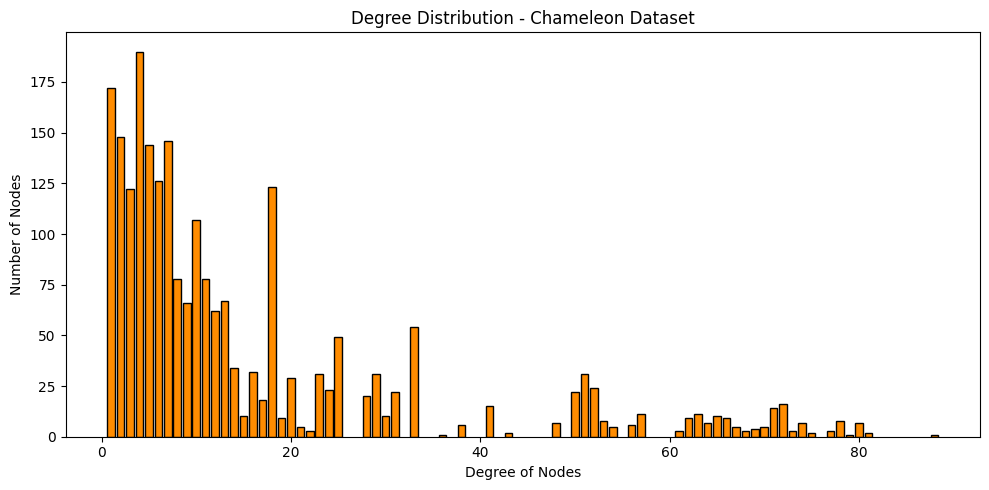

In [8]:
# Plot Degree Distribution:
deg = degree(data.edge_index[0], num_nodes=data.num_nodes).numpy().astype(int)
unique_degs, counts = np.unique(deg, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_degs, counts, color='darkorange', edgecolor='black')
plt.xlabel('Degree of Nodes')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution - Chameleon Dataset')
plt.tight_layout()
plt.show()

# **GCN Regression Model**

In [9]:
class GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels):
    super().__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, hidden_channels)
    self.dropout=torch.nn.Dropout(p=0.5)

    self.linear = torch.nn.Linear(hidden_channels, 1)
  def forward(self, x, edge_index):
    x = F.relu(self.conv1(x, edge_index))
    x = self.dropout(x)
    x = F.relu(self.conv2(x, edge_index))
    x = self.dropout(x)
    x = F.relu(self.conv3(x, edge_index))
    x = self.dropout(x)
    x = self.linear(x)
    return x.squeeze()

In [10]:
model = GCN(dataset.num_features, 64).to(device)
data  = data.to(device)
target = data.y.float()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.02, weight_decay=5e-4)
criterion= torch.nn.MSELoss()
print(model)

GCN(
  (conv1): GCNConv(2325, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


# **Training Model**

In [11]:
def train():
    model.train()
    optimizer.zero_grad()
    out  = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], target[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            out       = model(data.x, data.edge_index)
            test_loss = criterion(out[data.test_mask], target[data.test_mask]).item()
        print(f"Epoch {epoch:3d} | Train MSE: {loss:.4f} | Test MSE: {test_loss:.4f}")

Epoch  20 | Train MSE: 1.8241 | Test MSE: 1.9833
Epoch  40 | Train MSE: 1.3999 | Test MSE: 2.0270
Epoch  60 | Train MSE: 1.1103 | Test MSE: 1.7368
Epoch  80 | Train MSE: 0.9042 | Test MSE: 1.5848
Epoch 100 | Train MSE: 0.8382 | Test MSE: 1.6269
Epoch 120 | Train MSE: 0.7569 | Test MSE: 1.6187
Epoch 140 | Train MSE: 0.6914 | Test MSE: 1.5509
Epoch 160 | Train MSE: 0.6958 | Test MSE: 1.5600
Epoch 180 | Train MSE: 0.6637 | Test MSE: 1.4662
Epoch 200 | Train MSE: 0.6688 | Test MSE: 1.5218


# **Evaluating Model**

In [13]:
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index)

y_true = target[data.test_mask].cpu().numpy()
y_pred = predictions[data.test_mask].cpu().numpy()

mse  = mean_squared_error(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MSE  : {mse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

MSE  : 1.5218
MAE  : 0.9454
RMSE : 1.2336


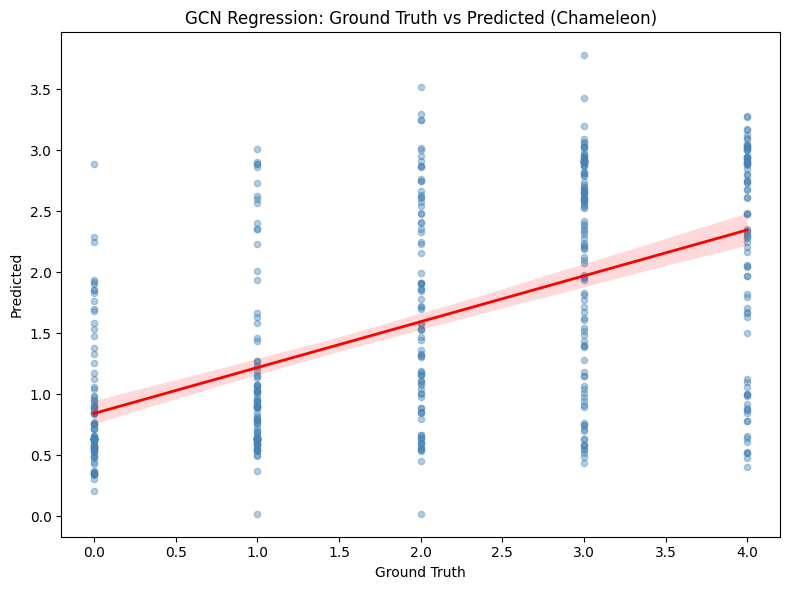

In [14]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x=y_true,
    y=y_pred,
    scatter_kws={'alpha': 0.4, 'color': 'steelblue', 's': 20},
    line_kws={'color': 'red', 'linewidth': 2}
)
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.title('GCN Regression: Ground Truth vs Predicted (Chameleon)')
plt.tight_layout()
plt.show()